# Information Bottleneck theory for Deep Learning

This is a demonstration of the information bottleneck theory for deep learning, introduced by Naftali Tishby. Here I tried to reproduce the main results in their recent paper [Opening the black box of Deep Neural Networks via Information](https://arxiv.org/pdf/1703.00810.pdf).

## Data generation

First, we will generate a very simple dataset for the demonstration. The inputs are vectors of 10 binaries, and the outputs are just single binaries. The inputs could be represented by integers from 0 to 1023 ($=2^{10}-1$). The 1024 possible inputs are divided into 16 groups (each group has 64 numbers), and each integer input $n\in[0,1023]$ belongs to group $i$ if $x\equiv i \pmod{16}$, where $i \in [0,15]$. Each group $i$ is then associated with a random binary number (output).

In [1]:
import numpy as np
from random import randint, seed

In [2]:
n_epochs = 10000

n_train_samples = 2000 # number of train samples
n_test_samples = 500 # number of test samples

groups = np.append(np.zeros(8),np.ones(8)) # 16 groups
np.random.seed(1234)
np.random.shuffle(groups)

# generate samples
seed(1234)
def generate_samples(n_samples):
    x_data = np.zeros((n_samples, 10)) # inputs
    x_int = np.zeros(n_samples) # integers representing the inputs
    y_data = np.zeros((n_samples, 2)) # outputs
    
    for i in range(n_samples):
        random_int = randint(0, 1023)
        x_data[i,:] = [int(b) for b in list("{0:b}".format(random_int).zfill(10))]
        x_int[i] = random_int
        y_data[i,0] = groups[random_int % 16]
        y_data[i,1] = 1 - y_data[i,0]
        
    return x_data, y_data, x_int

x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset

For our dataset, the theoritical mutual information between $X$ and $Y$ would be
\begin{align}
I(X;Y) & = \sum_{x\in X, y\in Y}P(x,y)\log\Big(\frac{P(x,y)}{P(x)P(y)}\Big) \\
& = \sum_{x\in X}\Big[P(x,y=0)\log\Big(\frac{P(x,y=0)}{P(x)P(y=0)}\Big) + P(x,y=1)\log\Big(\frac{P(x,y=1)}{P(x)P(y=1)}\Big)\Big] \\
& = 1024 \Big[ \frac{1}{1024}\log\Big(\frac{1/1024}{0.5/1024}\Big) + 0\Big] \\
& = 0.693.
\end{align}
Note that terms with $P(x,y)=0$ are set to $0$ for entropy calculation.

## Neural network

Then we are going to build a fully-connected neural networks with 3 hidden layers, which have 8, 6 and 4 neurons respectively. First let's define a fully-connected layer and a output layer using Tensorflow:

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def fully_conn(tensor, n_outputs, name):
    size = tensor.get_shape().as_list()[1]
    
    # weight and bias tensor
    weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    bias = tf.nn.bias_add(tensor, bias)
    
    # hyperbolic tangent activation
    tensor = tf.tanh(tensor, name=name)
    
    return tensor

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
tf.__version__

'2.2.0'

For the output layer, there would be no activation function:

In [5]:
def output(tensor, n_outputs):
    size = tensor.get_shape().as_list()[1]
    
    # weight and bias tensor
    weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    bias = tf.nn.bias_add(tensor, bias)
    
    return tensor

Now we could use the building blocks defined above to define a multilayer perceptron (MLP) model:

In [6]:
def mlp(x, n_neurons): # x is the input layer    
    # hidden layers
    hidden = x
    for n in range(len(n_neurons)):
        hidden = fully_conn(hidden, n_neurons[n], 'hidden%s' % (n+1))
    
    # output layer
    y = output(hidden, 2)
    
    return y

It's time to build our network!

In [7]:
def build_network(hidden_layer_neurons):
    global x, y, logits, cost, optimizer, accuracy, std_of_output
    
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 10), name='x')
    y = tf.placeholder(tf.float32, (None, 2), name='y')

    tf.set_random_seed(12345)
    logits = mlp(x, hidden_layer_neurons)
    logits = tf.identity(logits, name='logits')

    # TODO
    #std_of_output = tf.math.reduce_std(tf.reduce_mean(logits,axis=0))
    std_of_output = tf.reduce_mean(logits,axis=0)
    
    # cross-entropy coss function
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y), name='cost')
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.04).minimize(cost)
    
    # accuracy
    correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
def print_out_summary(sess, epoch):
    acc, loss, std = sess.run([accuracy, cost, std_of_output], feed_dict={x: x_test, y: y_test})
    #print('Epoch {:>4}:  Testing accuracy {:>.4f} - Testing loss {:>.4f} - std_of_output {:>.4f}'.format(epoch, acc, loss, std))
    print('Epoch {:>4}:  Testing accuracy {:>.4f} - Testing loss {:>.4f} - std_of_output '.format(epoch, acc, loss) + str(std))

build_network([8,6,4]) # 3 hidden layers with 8, 6 and 4 neurons respectively

Let's first train the network without calculating the mutual information to make sure we have the correct results.

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # initialization
    
    for epoch in range(n_epochs):
        sess.run(optimizer, feed_dict={x: x_train, y: y_train})
        if epoch % 100 == 0: print_out_summary(sess, epoch)

Epoch    0:  Testing accuracy 0.4980 - Testing loss 0.7717 - std_of_output [0.57029676 0.57545394]
Epoch  100:  Testing accuracy 0.5080 - Testing loss 0.7134 - std_of_output [0.26140556 0.24822143]
Epoch  200:  Testing accuracy 0.5260 - Testing loss 0.7013 - std_of_output [0.14651807 0.12323651]
Epoch  300:  Testing accuracy 0.5300 - Testing loss 0.6962 - std_of_output [0.09713601 0.07151581]
Epoch  400:  Testing accuracy 0.5500 - Testing loss 0.6925 - std_of_output [0.07269483 0.04821322]
Epoch  500:  Testing accuracy 0.5560 - Testing loss 0.6889 - std_of_output [0.05852273 0.03670409]
Epoch  600:  Testing accuracy 0.5680 - Testing loss 0.6853 - std_of_output [0.04887403 0.03050599]
Epoch  700:  Testing accuracy 0.5640 - Testing loss 0.6816 - std_of_output [0.04151367 0.02675718]
Epoch  800:  Testing accuracy 0.5680 - Testing loss 0.6776 - std_of_output [0.03543853 0.02443637]
Epoch  900:  Testing accuracy 0.5680 - Testing loss 0.6733 - std_of_output [0.02998619 0.0235254 ]
Epoch 1000

Epoch 8200:  Testing accuracy 1.0000 - Testing loss 0.0065 - std_of_output [ 0.05339711 -0.04113667]
Epoch 8300:  Testing accuracy 1.0000 - Testing loss 0.0063 - std_of_output [ 0.05231256 -0.04027211]
Epoch 8400:  Testing accuracy 1.0000 - Testing loss 0.0061 - std_of_output [ 0.05117841 -0.03934547]
Epoch 8500:  Testing accuracy 1.0000 - Testing loss 0.0059 - std_of_output [ 0.05000576 -0.03836861]
Epoch 8600:  Testing accuracy 1.0000 - Testing loss 0.0057 - std_of_output [ 0.04880458 -0.03735195]
Epoch 8700:  Testing accuracy 1.0000 - Testing loss 0.0055 - std_of_output [ 0.04757354 -0.03629516]
Epoch 8800:  Testing accuracy 1.0000 - Testing loss 0.0054 - std_of_output [ 0.04632208 -0.03520854]
Epoch 8900:  Testing accuracy 1.0000 - Testing loss 0.0052 - std_of_output [ 0.04505586 -0.03409809]
Epoch 9000:  Testing accuracy 1.0000 - Testing loss 0.0051 - std_of_output [ 0.04377578 -0.03296537]
Epoch 9100:  Testing accuracy 1.0000 - Testing loss 0.0049 - std_of_output [ 0.04248833 -0.

The training is pretty successfully, at about 1600 steps we reached 100% accuracy for the test dataset, which is what we would expect for a simple dataset like this.

## Mutual information

Now we are ready to explore the information bottleneck theory for our network. To estimate the mutual information between all the hidden layers and intput/output layers, we could binned the output activations as stated in the paper  (here we choose 30 bins, the same as in the paper), so that the hidden layer random variables $T_i$ (each $i$ corresponds to one hidden layer) would be discrete. Then, we will be able to estimate the joint distribution $P(X,T_i)$ and $P(T_i,Y)$, and use them to calculate the encoder mutual information (between input $X$ and hidden layer $T_i$)
\begin{equation}
    I(X;T_i) = \sum_{x\in X, t\in T_i}P(x,t)\log\Big(\frac{P(x,t)}{P(x)P(t)}\Big)
\end{equation}

and decoder mutual information (between hidden layer $T_i$ and desired output $Y$, note that it is not the model output $\widehat{Y}$)
\begin{equation}
    I(T_i;Y) = \sum_{t\in T_i, y\in Y}P(t,y)\log\Big(\frac{P(t,y)}{P(t)P(y)}\Big).
\end{equation}

In [9]:
from collections import Counter

def calc_mutual_information(hidden):
    n_neurons = hidden.shape[1]
  
    # discretization 
    n_bins = 30
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    
    
    # initialize pdfs
    pdf_x = Counter(); pdf_y = Counter(); pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()

    for i in range(n_train_samples):
        pdf_x[x_train_int[i]] += 1/float(n_train_samples)
        pdf_y[y_train[i,0]] += 1/float(n_train_samples)      
        pdf_xt[(x_train_int[i],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_yt[(y_train[i,0],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_t[tuple(indices[i,:])] += 1/float(n_train_samples)
    
    # calcuate encoder mutual information I(X;T)
    mi_xt = 0
    for i in pdf_xt:
        # P(x,t), P(x) and P(t)
        p_xt = pdf_xt[i]; p_x = pdf_x[i[0]]; p_t = pdf_t[i[1:]]
        # I(X;T)
        mi_xt += p_xt * np.log(p_xt / p_x / p_t)
 
    # calculate decoder mutual information I(T;Y)
    mi_ty = 0
    for i in pdf_yt:
        # P(t,y), P(t) and P(y)
        p_yt = pdf_yt[i]; p_t = pdf_t[i[1:]]; p_y = pdf_y[i[0]]
        # I(X;T)
        mi_ty += p_yt * np.log(p_yt / p_t / p_y)
            
    return mi_xt, mi_ty

# get mutual information for all hidden layers
def get_mutual_information(hiddens):
    mi_xt_list = []; mi_ty_list = []
    for hidden in hiddens:
        mi_xt, mi_ty = calc_mutual_information(hidden)
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list

We are now able to estimate the mutual information while training the network. We'll save the mutual information for later use.

In [10]:
def get_hidden_layers(names):
    hidden_layers = []
    for name in names:
        hidden_layers.append(tf.get_default_graph().get_tensor_by_name("%s:0" % name))
    return hidden_layers

# train the neural network and obtain mutual information
def train_with_mi(n_epochs, n_hidden_layers):
    mi_xt_all = []; mi_ty_all = []; epochs = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) # initialization
    
        hidden_layer_names = ['hidden%s' % i for i in range(1,n_hidden_layers+1)]
        for epoch in range(n_epochs):
            _, hidden_layers = sess.run([optimizer,
                                         get_hidden_layers(hidden_layer_names)],
                                        feed_dict={x: x_train, y: y_train})
                        
            if epoch % 100 == 0: print_out_summary(sess, epoch)
                
            if epoch % 20 == 0:
                mi_xt, mi_ty = get_mutual_information(hidden_layers)
                mi_xt_all.append(mi_xt)
                mi_ty_all.append(mi_ty)
                epochs.append(epoch)
    
    return np.array(mi_xt_all), np.array(mi_ty_all), np.array(epochs)

n_hidden_layers = 3
mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)

Epoch    0:  Testing accuracy 0.4980 - Testing loss 0.7717 - std_of_output [0.57029676 0.57545394]
Epoch  100:  Testing accuracy 0.5080 - Testing loss 0.7134 - std_of_output [0.26140556 0.24822143]
Epoch  200:  Testing accuracy 0.5260 - Testing loss 0.7013 - std_of_output [0.14651807 0.12323651]
Epoch  300:  Testing accuracy 0.5300 - Testing loss 0.6962 - std_of_output [0.09713601 0.07151581]
Epoch  400:  Testing accuracy 0.5500 - Testing loss 0.6925 - std_of_output [0.07269483 0.04821322]
Epoch  500:  Testing accuracy 0.5560 - Testing loss 0.6889 - std_of_output [0.05852273 0.03670409]
Epoch  600:  Testing accuracy 0.5680 - Testing loss 0.6853 - std_of_output [0.04887403 0.03050599]
Epoch  700:  Testing accuracy 0.5640 - Testing loss 0.6816 - std_of_output [0.04151367 0.02675718]
Epoch  800:  Testing accuracy 0.5680 - Testing loss 0.6776 - std_of_output [0.03543853 0.02443637]
Epoch  900:  Testing accuracy 0.5680 - Testing loss 0.6733 - std_of_output [0.02998619 0.0235254 ]
Epoch 1000

Epoch 8200:  Testing accuracy 1.0000 - Testing loss 0.0065 - std_of_output [ 0.05339711 -0.04113667]
Epoch 8300:  Testing accuracy 1.0000 - Testing loss 0.0063 - std_of_output [ 0.05231256 -0.04027211]
Epoch 8400:  Testing accuracy 1.0000 - Testing loss 0.0061 - std_of_output [ 0.05117841 -0.03934547]
Epoch 8500:  Testing accuracy 1.0000 - Testing loss 0.0059 - std_of_output [ 0.05000576 -0.03836861]
Epoch 8600:  Testing accuracy 1.0000 - Testing loss 0.0057 - std_of_output [ 0.04880458 -0.03735195]
Epoch 8700:  Testing accuracy 1.0000 - Testing loss 0.0055 - std_of_output [ 0.04757354 -0.03629516]
Epoch 8800:  Testing accuracy 1.0000 - Testing loss 0.0054 - std_of_output [ 0.04632208 -0.03520854]
Epoch 8900:  Testing accuracy 1.0000 - Testing loss 0.0052 - std_of_output [ 0.04505586 -0.03409809]
Epoch 9000:  Testing accuracy 1.0000 - Testing loss 0.0051 - std_of_output [ 0.04377578 -0.03296537]
Epoch 9100:  Testing accuracy 1.0000 - Testing loss 0.0049 - std_of_output [ 0.04248833 -0.

## Visualization

Below is a movie showing the evolution of the hidden layers with the training epochs in the information plane. We can clearly see two distinct optimization phases in the information plane, as discussed in the paper. During the first *empirical error minimization* (ERM) phase (until around epoch 1500), the information on the outputs $I_Y$ increases quickly, and then during the second *representation compression* phase (from around epoch 1500 onwards), the information on the inputs $I_X$ decreases. The evolution is not as smooth as shown in the paper, because it is the result of only one network, instead of average of multiple networks. 

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((3,7))
ax.set_ylim((0.1,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
plt.close(fig)

In [13]:
cmap = plt.cm.get_cmap('cool')

def animate(i):
    title.set_text('Epoch %s' % str(epochs[i]).zfill(4))
    ax.plot(mi_xt_all[i,:], mi_ty_all[i,:], 'k-',alpha=0.2)
    if i > 0:
        for j in range(n_hidden_layers):
            ax.plot(mi_xt_all[(i-1):(i+1),j],mi_ty_all[(i-1):(i+1),j],'.-',c=cmap(j*.2),ms=10)
    return

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=None,
                               frames=len(epochs),
                               interval=100)
HTML(anim.to_html5_video())

**Note**: Github cannot render the movies embedded in the notebook. You could view the movies from this notebook through nbviewer: https://nbviewer.jupyter.org/github/stevenliuyi/information-bottleneck/blob/master/information_bottleneck.ipynb

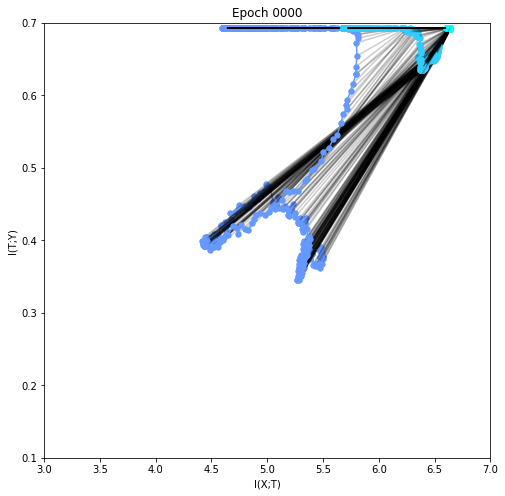

In [14]:
ax.set_title('Epoch 0000 - 2999')
fig # show full evolution process

## More hidden layers

Finally, we try to use 5 hidden layers instead of 3. The number of neurons in the layers are 8, 7, 6, 5 and 3 respectively. Still, two optimzation phases are clearly seen in the information plane.

In [15]:
n_hidden_layers = 5
build_network([8,7,6,5,3]) # 5 hidden layers
mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)

Epoch    0:  Testing accuracy 0.5100 - Testing loss 0.7468 - std_of_output [0.00220745 0.34999624]
Epoch  100:  Testing accuracy 0.5580 - Testing loss 0.6979 - std_of_output [0.04853914 0.09202112]
Epoch  200:  Testing accuracy 0.5960 - Testing loss 0.6722 - std_of_output [0.07344823 0.05776736]
Epoch  300:  Testing accuracy 0.6300 - Testing loss 0.6538 - std_of_output [0.06749701 0.0621056 ]
Epoch  400:  Testing accuracy 0.6460 - Testing loss 0.6390 - std_of_output [0.04899606 0.07278886]
Epoch  500:  Testing accuracy 0.6720 - Testing loss 0.6265 - std_of_output [0.0249928  0.08563403]
Epoch  600:  Testing accuracy 0.6720 - Testing loss 0.6160 - std_of_output [-0.00087873  0.09911262]
Epoch  700:  Testing accuracy 0.6700 - Testing loss 0.6071 - std_of_output [-0.02357855  0.10829593]
Epoch  800:  Testing accuracy 0.6780 - Testing loss 0.5984 - std_of_output [-0.04360441  0.11554724]
Epoch  900:  Testing accuracy 0.6980 - Testing loss 0.5891 - std_of_output [-0.06053244  0.12071426]
Ep

Epoch 8200:  Testing accuracy 0.9980 - Testing loss 0.0069 - std_of_output [-0.55527407  0.55445606]
Epoch 8300:  Testing accuracy 0.9980 - Testing loss 0.0068 - std_of_output [-0.55596864  0.55515367]
Epoch 8400:  Testing accuracy 0.9980 - Testing loss 0.0067 - std_of_output [-0.5566552  0.5558434]
Epoch 8500:  Testing accuracy 0.9980 - Testing loss 0.0065 - std_of_output [-0.557331    0.55652255]
Epoch 8600:  Testing accuracy 0.9980 - Testing loss 0.0064 - std_of_output [-0.5580006  0.5571954]
Epoch 8700:  Testing accuracy 0.9980 - Testing loss 0.0063 - std_of_output [-0.55866337  0.55786145]
Epoch 8800:  Testing accuracy 0.9980 - Testing loss 0.0062 - std_of_output [-0.5593195  0.558521 ]
Epoch 8900:  Testing accuracy 0.9980 - Testing loss 0.0061 - std_of_output [-0.5599707   0.55917543]
Epoch 9000:  Testing accuracy 0.9980 - Testing loss 0.0060 - std_of_output [-0.5606163   0.55982447]
Epoch 9100:  Testing accuracy 0.9980 - Testing loss 0.0059 - std_of_output [-0.5612565   0.560468

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((2,7))
ax.set_ylim((0.1,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
plt.close(fig)

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=None,
                               frames=len(epochs),
                               interval=100)
HTML(anim.to_html5_video())

**Note**: Github cannot render the movies embedded in the notebook. You could view the movies from this notebook through nbviewer: https://nbviewer.jupyter.org/github/stevenliuyi/information-bottleneck/blob/master/information_bottleneck.ipynb

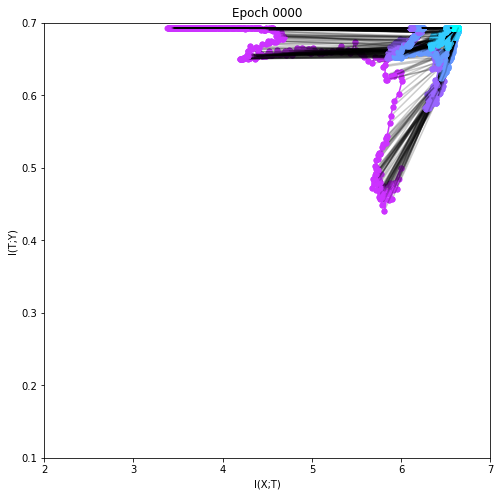

In [19]:
ax.set_title('Epoch 0000 - 2999')
fig # show full evolution process

In [20]:
n_hidden_layers = 4
build_network([5]*4) # 5 hidden layers
mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)

Epoch    0:  Testing accuracy 0.4840 - Testing loss 0.7349 - std_of_output [0.302601   0.24422269]
Epoch  100:  Testing accuracy 0.5260 - Testing loss 0.6985 - std_of_output [-0.05132273  0.01740366]
Epoch  200:  Testing accuracy 0.5440 - Testing loss 0.6914 - std_of_output [-0.05648781  0.01876129]
Epoch  300:  Testing accuracy 0.5680 - Testing loss 0.6872 - std_of_output [-0.05308195  0.01719635]
Epoch  400:  Testing accuracy 0.5840 - Testing loss 0.6836 - std_of_output [-0.05599435  0.01660595]
Epoch  500:  Testing accuracy 0.5820 - Testing loss 0.6801 - std_of_output [-0.0605826   0.01754031]
Epoch  600:  Testing accuracy 0.5860 - Testing loss 0.6767 - std_of_output [-0.06403222  0.01833225]
Epoch  700:  Testing accuracy 0.6000 - Testing loss 0.6736 - std_of_output [-0.06566898  0.01847919]
Epoch  800:  Testing accuracy 0.6140 - Testing loss 0.6710 - std_of_output [-0.06565147  0.01794286]
Epoch  900:  Testing accuracy 0.6240 - Testing loss 0.6687 - std_of_output [-0.0638985   0.01

Epoch 8200:  Testing accuracy 0.9980 - Testing loss 0.0221 - std_of_output [-0.3537639  0.3990987]
Epoch 8300:  Testing accuracy 0.9980 - Testing loss 0.0203 - std_of_output [-0.3578236   0.40431756]
Epoch 8400:  Testing accuracy 0.9980 - Testing loss 0.0188 - std_of_output [-0.3628363   0.41053143]
Epoch 8500:  Testing accuracy 0.9980 - Testing loss 0.0176 - std_of_output [-0.368175    0.41704604]
Epoch 8600:  Testing accuracy 0.9980 - Testing loss 0.0166 - std_of_output [-0.37352747  0.42351803]
Epoch 8700:  Testing accuracy 0.9980 - Testing loss 0.0158 - std_of_output [-0.37873548  0.42977703]
Epoch 8800:  Testing accuracy 0.9980 - Testing loss 0.0150 - std_of_output [-0.38373035  0.4357524 ]
Epoch 8900:  Testing accuracy 0.9980 - Testing loss 0.0144 - std_of_output [-0.38847947  0.4414124 ]
Epoch 9000:  Testing accuracy 0.9980 - Testing loss 0.0138 - std_of_output [-0.39297667  0.446756  ]
Epoch 9100:  Testing accuracy 0.9980 - Testing loss 0.0132 - std_of_output [-0.39722148  0.45

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((2,7))
ax.set_ylim((0.1,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
plt.close(fig)

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=None,
                               frames=len(epochs),
                               interval=100)
HTML(anim.to_html5_video())

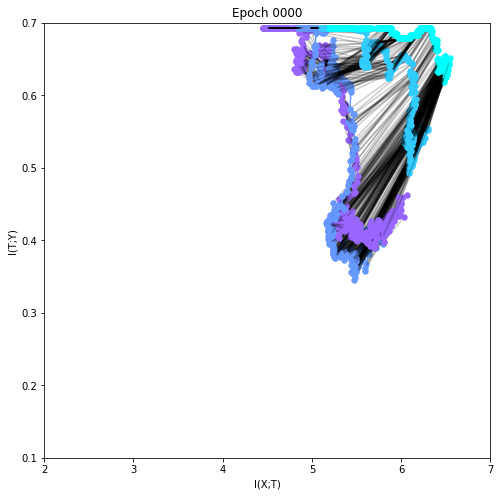

In [22]:
ax.set_title('Epoch 0000 - 2999')
fig # show full evolution process